# Отток клиентов телекоммуникационных компаний

### Content
* [Подготовка к работе](#preload)
* [EDA, Preprocessing & Feature Engineering](#eda)
  * [Общий обзор данных](#eda_preview)
  * [Оценка NaN значений](#eda_nan)
  * [Оценка категориальных признаков](#eda_catfeat)
  * [Визуальный анализ](#eda_visual)
* [Models и выводы](#model)
  * [sklearn](#model_sklearn)
  * [XGBoost](#model_XGBoost)
  * [CatBoost](#model_CatBoost)
  * [LightGBM](#model_LightGBM)

## Подготовка к работе <a class="anchor" id="preload"/>

In [1]:
# preload local libs
import sys
import os
import pathlib

project_dir = str(pathlib.Path(os.getcwd()).parent.resolve())
if project_dir not in sys.path:
    sys.path.insert(1, project_dir)

# project_dir

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
# from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# import kagglehub

from lib import utils

import warnings

warnings.filterwarnings("ignore")

In [3]:
# Download latest version
# path = kagglehub.dataset_download("blastchar/telco-customer-churn")
# print("Path to dataset files:", path)

# Download from local copy
dataset_dir = project_dir + '/datasets/telco-customer-churn/versions/1'

# for dirname, _, filenames in os.walk(dataset_dir):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

df_src = pd.read_csv(dataset_dir + "/WA_Fn-UseC_-Telco-Customer-Churn.csv", delimiter=",")
# df = df_src.copy()

In [4]:
def object_to_int(dataframe_series):
    if dataframe_series.dtype == 'object':
        dataframe_series = LabelEncoder().fit_transform(dataframe_series)
    return dataframe_series

## EDA <a class="anchor" id="eda"/>

### Общий обзор даных <a class="anchor" id="eda_preview"/>

In [5]:
df = df_src.copy()

In [6]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [8]:
df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

Поле TotalCharges имеет неестественный тип object. Приведем тип к float.
Поле customerID имеет уникальные значения, удалим его сразу.

In [9]:
# Для каждой object-колонки пытаемся преобразовать в float и отмечаем, где не получилось
df['TotalCharges'] = df['TotalCharges'].apply(
    lambda col: pd.to_numeric(col, errors='coerce')
)

df = df.drop(columns=['customerID'])

In [10]:
# Количество пропусков по признакам
df.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [11]:
pd.options.display.float_format = "{:.2f}".format
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.00,7043.00,7043.00,7032.00
mean,0.16,32.37,64.76,2283.30
std,0.37,24.56,30.09,2266.77
min,0.00,0.00,18.25,18.80
25%,0.00,9.00,35.50,401.45
50%,0.00,29.00,70.35,1397.47
75%,0.00,55.00,89.85,3794.74
max,1.00,72.00,118.75,8684.80


### Оценка NaN значений <a class="anchor" id="eda_nan"/>

Посмотрим на пустые значения

In [12]:
df[np.isnan(df['TotalCharges'])]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


Для полей, где у клиента отсутствуют платежи также нулевое поле tunure, то есть, получается, что клиент и не был в компании.

По полю общей оплаты есть пропуски, удалим их

In [13]:
df.dropna(inplace=True)

Заодно проверим наличие клиентов, которые не были в компании, но оплачивали услуги

In [14]:
df[df['tenure'] == 0]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


Для наглядности переведем целевую переменную к бинарному значению

In [15]:
df['Churn'].replace(to_replace='Yes', value=1, inplace=True)
df['Churn'].replace(to_replace='No',  value=0, inplace=True)

### Оценка категориальных признаков <a class="anchor" id="eda_catfeat"/>

In [16]:
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

In [17]:
# категориальные признаки
object_columns = df.select_dtypes(include=['object']).columns.to_list()
# числовые признаки
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns.to_list()

print('Разнообразие значений категориальных переменных:')
for object_col in object_columns:
    print(f'  {object_col}:', len(df[object_col].unique()))
    if len(df[object_col].unique()) < 10:
        print('  Values:', ', '.join(df[object_col].unique().tolist()))
    print()

Разнообразие значений категориальных переменных:
  gender: 2
  Values: Female, Male

  Partner: 2
  Values: Yes, No

  Dependents: 2
  Values: No, Yes

  PhoneService: 2
  Values: No, Yes

  MultipleLines: 3
  Values: No phone service, No, Yes

  InternetService: 3
  Values: DSL, Fiber optic, No

  OnlineSecurity: 3
  Values: No, Yes, No internet service

  OnlineBackup: 3
  Values: Yes, No, No internet service

  DeviceProtection: 3
  Values: No, Yes, No internet service

  TechSupport: 3
  Values: No, Yes, No internet service

  StreamingTV: 3
  Values: No, Yes, No internet service

  StreamingMovies: 3
  Values: No, Yes, No internet service

  Contract: 3
  Values: Month-to-month, One year, Two year

  PaperlessBilling: 2
  Values: Yes, No

  PaymentMethod: 4
  Values: Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)



In [ ]:
# Приведем в ручном режиме для наглядности, по схожему с OneHotEncoder образу к числовому виду категориальные признаки

df_enc = df.copy()

df_enc['HasInternetService']    = (df_enc['InternetService'] != 'No').astype(int)
df_enc['InternetService_DSL']   = (df_enc['InternetService'] == 'DSL').astype(int)

df_enc['HasPhoneService']       = (df_enc['PhoneService'] == 'Yes').astype(int)
df_enc['HasMultipleLines']      = (df_enc['MultipleLines'] == 'Yes').astype(int)
df_enc['IsMale']                = (df_enc['gender'] == 'Male').astype(int)
df_enc['HasPartner']            = (df_enc['Partner'] == 'Yes').astype(int)
df_enc['HasDependents']         = (df_enc['Dependents'] == 'Yes').astype(int)
df_enc['HasPaperlessBilling']   = (df_enc['PaperlessBilling'] == 'Yes').astype(int)

# Тернарные признаки приведем к бинарным, так как значение третьего признака уже есть в другом признаке

df_enc['OnlineSecurity']        = (df_enc['OnlineSecurity'] == 'Yes').astype(int)
df_enc['OnlineBackup']          = (df_enc['OnlineBackup'] == 'Yes').astype(int)
df_enc['DeviceProtection']      = (df_enc['DeviceProtection'] == 'Yes').astype(int)
df_enc['TechSupport']           = (df_enc['TechSupport'] == 'Yes').astype(int)
df_enc['StreamingTV']           = (df_enc['StreamingTV'] == 'Yes').astype(int)
df_enc['StreamingMovies']       = (df_enc['StreamingMovies'] == 'Yes').astype(int)

# Разделим способы оплаты на автоматические и другие

df_enc['AutoPaymentMethod'] = np.where(df_enc['PaymentMethod'].isin(['Electronic check', 'Mailed check']), 0, 1)

# удалим более ненужные колонки
df_enc.drop(columns=['InternetService', 'PhoneService', 'gender', 'Partner', 'Dependents', 'PaperlessBilling', 'MultipleLines'], inplace=True)

In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

categorical_cols = df_enc.select_dtypes(include=['object']).columns.tolist()

# Создаем пайплайн для категориальных признаков
cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(sparse_output=False))
])

# Создаем общий трансформер
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_pipeline, categorical_cols),
    ],
    remainder='passthrough'
)

# Преобразуем данные
encoded_data = preprocessor.fit_transform(df_enc)

# Получаем имена новых колонок
encoded_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_columns = list(encoded_columns) + [col for col in df_enc.columns if col not in categorical_cols]

# Преобразуем в DataFrame
encoded_df = pd.DataFrame(encoded_data, columns=all_columns)

In [20]:
encoded_df

,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen,tenure,OnlineSecurity,...,Churn,HasInternetService,InternetService_DSL,HasPhoneService,HasMultipleLines,IsMale,HasPartner,HasDependents,HasPaperlessBilling,AutoPaymentMethod
0,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,...,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00
1,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,34.00,1.00,...,0.00,1.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00
2,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,2.00,1.00,...,1.00,1.00,1.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00
3,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,45.00,1.00,...,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
4,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,2.00,0.00,...,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,24.00,1.00,...,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00
7028,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,72.00,0.00,...,0.00,1.00,0.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00
7029,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,11.00,1.00,...,0.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00
7030,1.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,4.00,0.00,...,1.00,1.00,0.00,1.00,1.00,1.00,1.00,0.00,1.00,0.00


### Визуальный анализ <a class="anchor" id="eda_visual"/>

Матрица корреляций с предварительным приведением полей к числовым значениям с LabelEncoding

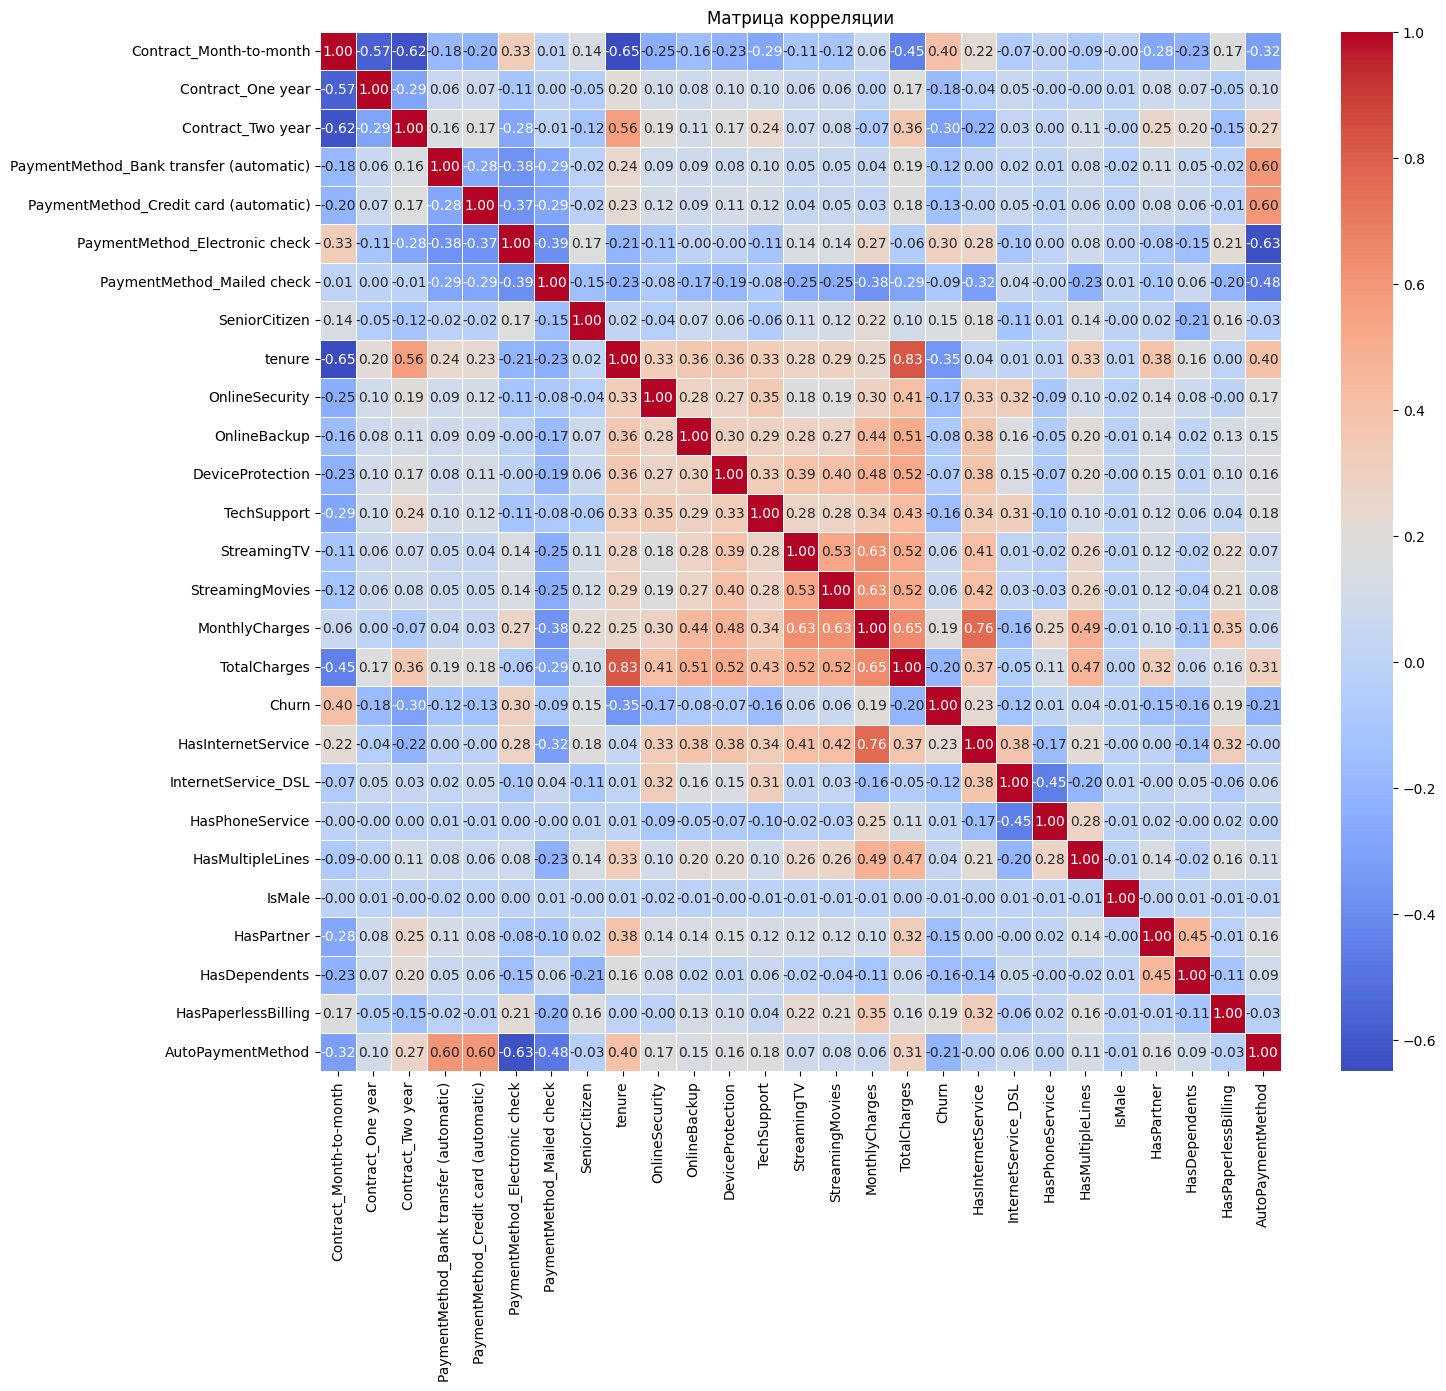

In [21]:
utils.corr_matrix_plot(encoded_df.corr(), 'Матрица корреляции')

In [22]:
X = encoded_df.drop(columns = ['Churn'])
y = encoded_df['Churn'].values

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 50, stratify=y)

## Models <a class="anchor" id="model"></a>

### sklearn <a class="anchor" id="model_sklearn"></a>

**Базовые настройки**

In [24]:
gb = GradientBoostingClassifier(random_state=50)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

print("{:.4f}".format(roc_auc_score(y_test, gb.predict_proba(X_test)[:, 1])))

0.8334


**С подбором параметров**

In [38]:
# Базовая модель
gb = GradientBoostingClassifier(random_state=50)

# Сетка параметров
param_grid = {
    'n_estimators': [30, 50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'min_samples_leaf': [5, 7, 9]
}

# GridSearch
grid_search = GridSearchCV(
    estimator=gb,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Лучшие параметры: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 7, 'n_estimators': 100, 'subsample': 0.6}


In [40]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=50, learning_rate=0.05, max_depth=3, min_samples_leaf=7, n_estimators=100, subsample=0.6)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

print("{:.4f}".format(roc_auc_score(y_test, gb.predict_proba(X_test)[:, 1])))

0.8375


### XGBoost <a class="anchor" id="model_XGBoost"></a>

**Базовые настройки**

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print("{:.4f}".format(roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1])))

0.8117


**С подбором параметров**

In [28]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.03, 0.05],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
}

# GridSearch
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=4,
)

# Обучаем поиск
grid_search.fit(X_train, y_train)

# Лучшие параметры
print("Лучшие параметры:", grid_search.best_params_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Лучшие параметры: {'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.6}


In [36]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', learning_rate=0.03, max_depth=3, n_estimators=200, subsample=0.6)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print("{:.4f}".format(roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1])))

0.8374


### CatBoost <a class="anchor" id="model_CatBoost"></a>

**Базовые настройки**

In [30]:
clf_base = CatBoostClassifier(logging_level='Silent')
clf_base.fit(X_train, y_train)

print("{:.4f}".format(roc_auc_score(y_test, clf_base.predict_proba(X_test)[:, 1])))

0.8294


**Подбор оптимального числа итераций**

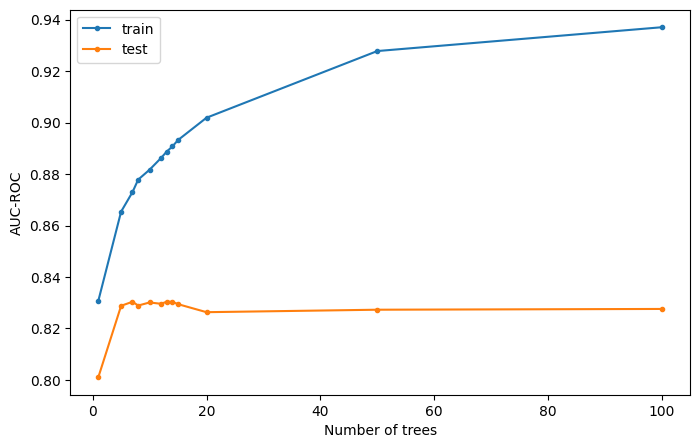

In [39]:
n_trees = [1, 5, 7, 8, 10, 12, 13, 14, 15, 20, 50, 100]
quals_train = []
quals_test = []
for n in n_trees:
    clf = CatBoostClassifier(iterations=n, logging_level='Silent')
    clf.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)
    
plt.figure(figsize=(8, 5))
plt.plot(n_trees, quals_train, marker='.', label='train')
plt.plot(n_trees, quals_test, marker='.', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

In [41]:
# Эмпирически подобранное оптимальное значение
n_trees_optimal = 14

In [42]:
# С оптимальным значением итераций
clf_t100 = CatBoostClassifier(iterations=n_trees_optimal, logging_level='Silent', cat_features=[])
clf_t100.fit(X_train, y_train)

print("{:.4f}".format(roc_auc_score(y_test, clf_t100.predict_proba(X_test)[:, 1])))

0.8304


**Подберем остальные параметры**

In [48]:
from itertools import product

iterations = [20, 50, 100, 150, 200]
depths = [4, 6, 8]
lrs = np.arange(0.04, 0.12, 0.01)
regs = [1, 3, 5]

best_score = 0
best_params = None

for iter, depth, lr, reg in product(iterations, depths, lrs, regs):
    clf = CatBoostClassifier(iterations=iter, learning_rate=lr, depth=depth, logging_level='Silent', cat_features=[], l2_leaf_reg=reg)
    clf.fit(X_train, y_train)

    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

    if roc_auc > best_score:
        best_score = roc_auc
        best_params = (iter, depth, float(lr), reg)

print(f"Лучшие параметры: {best_params}")
print(f"Лучший AUC: {best_score:.4f}")

Лучшие параметры: (200, 4, 0.04, 3)
Лучший AUC: 0.8392


In [50]:
# С остальными парамерами
clf_opt = CatBoostClassifier(iterations=200, learning_rate=0.04, depth=4, logging_level='Silent', cat_features=[], l2_leaf_reg=3)
clf_opt.fit(X_train, y_train)

print("{:.4f}".format(roc_auc_score(y_test, clf_opt.predict_proba(X_test)[:, 1])))

0.8392


### LightGBM <a class="anchor" id="model_LightGBM"></a>

**Базовые настройки**

In [51]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(verbose=-1, boosting_type="gbdt", device_type='gpu')
lgb.fit(X_train, y_train)

print("{:.4f}".format(roc_auc_score(y_test, lgb.predict_proba(X_test)[:, 1])))

0.8223


**С подбором параметров**

In [70]:
lgbm = LGBMClassifier(
    objective="binary",
    boosting_type="gbdt",
    device_type='gpu',  # GPU-режим
    random_state=50,
    n_jobs=2
)

param_grid = {
    'num_leaves': [10, 15, 31],
    'max_depth': [-1, 5, 10],
    'learning_rate': [0.01, 0.05],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    cv=3,                # 3-кратная кросс-валидация
    scoring='roc_auc',
    verbose=1,
    n_jobs=2
)

grid.fit(X_train, y_train)

print("Лучшие параметры:", grid.best_params_)
print("Лучшая точность (CV):", grid.best_score_)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 872, number of negative: 2409
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 629
[LightGBM] [Info] Number of data points in the train set: 3281, number of used features: 26
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 872, number of negative: 2409
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 629
[LightGBM] [Info] Number of data points in the train set: 3281, number of used features: 26
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM

In [75]:
lgb = LGBMClassifier(
    n_estimators=100, max_depth=8, num_leaves=10, learning_rate=0.05, verbose=-1, random_state=50,
    objective="binary", boosting_type="gbdt", device_type='gpu', colsample_bytree=0.8, subsample=0.8
)
lgb.fit(X_train, y_train)

print("{:.4f}".format(roc_auc_score(y_test, lgb.predict_proba(X_test)[:, 1])))

0.8384


Другой способ подбора

In [72]:
from itertools import product

iterations = [50, 100, 150, 200]
depths = [4, 6, 8]
lrs = np.arange(0.04, 0.12, 0.01)
leaves = [10, 15, 31]

best_score = 0
best_params = None

for iter, depth, lr, leave in product(iterations, depths, lrs, leaves):
    clf = LGBMClassifier(
        objective="binary",
        boosting_type="gbdt",
        device_type='gpu',  # GPU-режим
        random_state=50,
        n_estimators=iter,
        max_depth=depth,
        learning_rate=float(lr),
        num_leaves=leave,
        n_jobs=2
    )

    clf.fit(X_train, y_train)

    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

    if roc_auc > best_score:
        best_score = roc_auc
        best_params = (iter, depth, float(lr), leave)

print(f"Лучшие параметры: {best_params}")
print(f"Лучший AUC: {best_score:.4f}")

Лучшие параметры: (150, 8, 0.04, 10)
Лучший AUC: 0.8393


In [73]:
lgb = LGBMClassifier(n_estimators=150, max_depth=8, num_leaves=10, learning_rate=0.04, verbose=-1, random_state=50, objective="binary", boosting_type="gbdt", device_type='gpu')
lgb.fit(X_train, y_train)

print("{:.4f}".format(roc_auc_score(y_test, lgb.predict_proba(X_test)[:, 1])))

0.8393
